# **Topic Modeling with Quantized LLMs**
*Create easily interpretable topics with BERTopic and LLMs*
<br>

<img src="https://pbs.twimg.com/media/GDA2JQoX0AElWoq?format=jpg&name=large">


---
        
💡 **NOTE**: We will want to use a GPU to run both 7B LLMs as well as BERTopic for this use case. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

We will start by installing a number of packages that we are going to use throughout this example:

In [1]:
"""
#%%capture
# BERTopic + llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --no-cache-dir
!pip install bertopic datasets

# DataMapPlot
#!git clone https://github.com/TutteInstitute/datamapplot.git
#!pip install datamapplot/.
!pip install datamapplot
"""

'\n#%%capture\n# BERTopic + llama-cpp-python\n!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --no-cache-dir\n!pip install bertopic datasets\n\n# DataMapPlot\n#!git clone https://github.com/TutteInstitute/datamapplot.git\n#!pip install datamapplot/.\n!pip install datamapplot\n'

In [2]:
"""
# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64
"""

'\n# GPU-accelerated HDBSCAN + UMAP\n!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64\n'

In [3]:
from datasets import load_dataset
import pandas as pd
from llama_cpp import Llama
from bertopic.representation import KeyBERTInspired, LlamaCPP


# 📄 **Data**

We are going to apply topic modeling on a number of ArXiv abstracts. They are a great source for topic modeling since they contain a wide variety of topics and are generally well-written.

In [4]:

# ArXiv ML Documents
#docs = load_dataset("CShorten/ML-ArXiv-Papers")["train"]["abstract"]

csv_path = 'data/Trustpilot/www.darty.com_en.xlsx'
feedbacks_df = pd.read_excel(csv_path)
feedbacks_df['Date'] = pd.to_datetime(feedbacks_df['Date'], format='%B %d, %Y', errors='coerce')
feedbacks_df['Content'] = feedbacks_df['Content'].fillna('')
docs = feedbacks_df['Content']

In [5]:
docs

0        Always very good service from Darty. Product ...
1       Very much appreciated installing the machine a...
2        Ordered on the Darty website Bosch washing ma...
3       On November 8, 2023 I bought a computer from D...
4        False sale of free credit No response from th...
                              ...                        
8974     Good quality of telephone communications, ver...
8975     have just subscribed to the Darty Internet of...
8976     LUXEMBOURG after-sales service totally incomp...
8977     I am still very satisfied with this site, no ...
8978     I bought a Hoover brand "suction" vacuum clea...
Name: Content, Length: 8979, dtype: object

# 🦙 **Quantized LLM**

To use a quantized LLMs, we make use of the `GGUF` format together with `llama-cpp-python`. When you access any of [TheBloke's quantized models](https://huggingface.co/TheBloke), you can click on files and find specific quantized formats. We are going with a 4-bit quantized model:

In [6]:
#!wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/TheBloke/dolphin-2.7-mixtral-8x7b-GGUF/resolve/main/dolphin-2.7-mixtral-8x7b.Q3_K_M.gguf

Next, we load the model using `llama-cpp-python`:

In [12]:
model_path="/home/maitre/Documents/Models/mistral-7b-instruct-v0.1.Q5_K_M.gguf"
#model_path="/home/maitre/Documents/Development/text-generation-webui/models/mixtral-8x7b-instruct-v0.1.Q3_K_M.gguf"
# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=8096, stop=["Q:", "\n"])

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /home/maitre/Documents/Models/mistral-7b-instruct-v0.1.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv  

We pass the LLM to BERTopic with a custom prompt. Let's add `KeyBERTInspired` representations to compare the LLM representations with:

In [8]:

prompt_english = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you name this group of comments in at most 5 words?
A:
"""

prompt = """ Q:
J'ai le regroupement de commentaires suivants :
[DOCUMENTS]

Ce regroupement contient les mots-clés suivants : '[KEYWORDS]'.

Sur la base des informations ci-dessus, nomme cette cétegorie de commentaires. N'utilise pas plus de quelques mots.
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt_english),
}

# 🗨️ **BERTopic**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [9]:
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
import pickle
# from umap import UMAP
# from hdbscan import HDBSCAN


In [10]:

# Pre-calculate embeddings
#embedding_model = SentenceTransformer("BAAI/bge-small-en")
#embedding_model = SentenceTransformer("Salesforce/SFR-Embedding-Mistral")
#embedding_model = SentenceTransformer("intfloat/e5-mistral-7b-instruct")
#embedding_model = SentenceTransformer("intfloat/multilingual-e5-large-instruct")
embedding_model = SentenceTransformer("hkunlp/instructor-xl")


#embedding_model = SentenceTransformer("OrdalieTech/Solon-embeddings-large-0.1")
#embedding_model = SentenceTransformer("intfloat/multilingual-e5-large")

embeddings = embedding_model.encode(docs, prompt="Represent those customer feedbacks for clustering according to their categories. ", show_progress_bar=True, batch_size=32)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

Batches:   0%|          | 0/281 [00:00<?, ?it/s]

In [13]:

with open('embeddings-instructor-xl', 'wb') as f:
    pickle.dump(embeddings, f)

with open('embeddings-instructor-xl', 'rb') as f:
    embeddings = pickle.load(f)
    

In [14]:
# Define sub-models
min_cluster_size=20 #400
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [15]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-03-05 17:22:31,603 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-05 17:22:31,708 - BERTopic - Dimensionality - Completed ✓
2024-03-05 17:22:31,709 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-05 17:22:31,945 - BERTopic - Cluster - Completed ✓
2024-03-05 17:22:31,949 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/2 [00:00<?, ?it/s]
llama_print_timings:        load time =    1760.64 ms
llama_print_timings:      sample time =       4.56 ms /    16 runs   (    0.29 ms per token,  3505.70 tokens per second)
llama_print_timings: prompt eval time =   15890.35 ms /  3580 tokens (    4.44 ms per token,   225.29 tokens per second)
llama_print_timings:        eval time =    3248.84 ms /    15 runs   (  216.59 ms per token,     4.62 tokens per second)
llama_print_timings:       total time =   19194.33 ms /  3595 tokens
 50%|█████     | 1/2 [00:19<00:19, 19.21s/it]Lla

Now that we are done training our model, let's see what topics were generated:

In [16]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,0,8636,0_the_to_and_of,"[the, to, and, of, it, that, darty, for, in, is]","[service, no, customer, problem, darty, very, ...","[\n### 5. Topic 16: Amazon Web Services (A, , ...",[We can't put 0 and that's a shame. I bought a...
1,1,343,1_diet_prep_meal_my,"[diet, prep, meal, my, is, children, in, for, ...","[excellent, well, good, thanks, prepping, grea...","[Meal Prep, Diet, Children, In, Society, Achie...","[ the questionnaire is very well done, I have..."


In [20]:
topic_model.get_topic_info().iloc[0]

Topic                                                                  0
Count                                                               8636
Name                                                     0_the_to_and_of
Representation          [the, to, and, of, it, that, darty, for, in, is]
KeyBERT                [service, no, customer, problem, darty, very, ...
LLM                    [\n### 5. Topic 16: Amazon Web Services (A, , ...
Representative_Docs    [We can't put 0 and that's a shame. I bought a...
Name: 0, dtype: object

# 📊 Visualization with DataMapPlot

In [18]:
import PIL
import numpy as np
import requests

# Prepare logo
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

We can use the labels created by the LLM and assign them to topics that we have created:

In [24]:
llm_labels

['Unlabelled', 'Meal Prep Diet Children In Society Achieving']

/home/maitre/anaconda3/envs/vigie_env/lib/python3.10/site-packages/datamapplot/text_placement.py:53: RuntimeWarning: invalid value encountered in divide
  recentered_label_locations / row_norm(recentered_label_locations)[:, None]


ValueError: Input contains NaN.

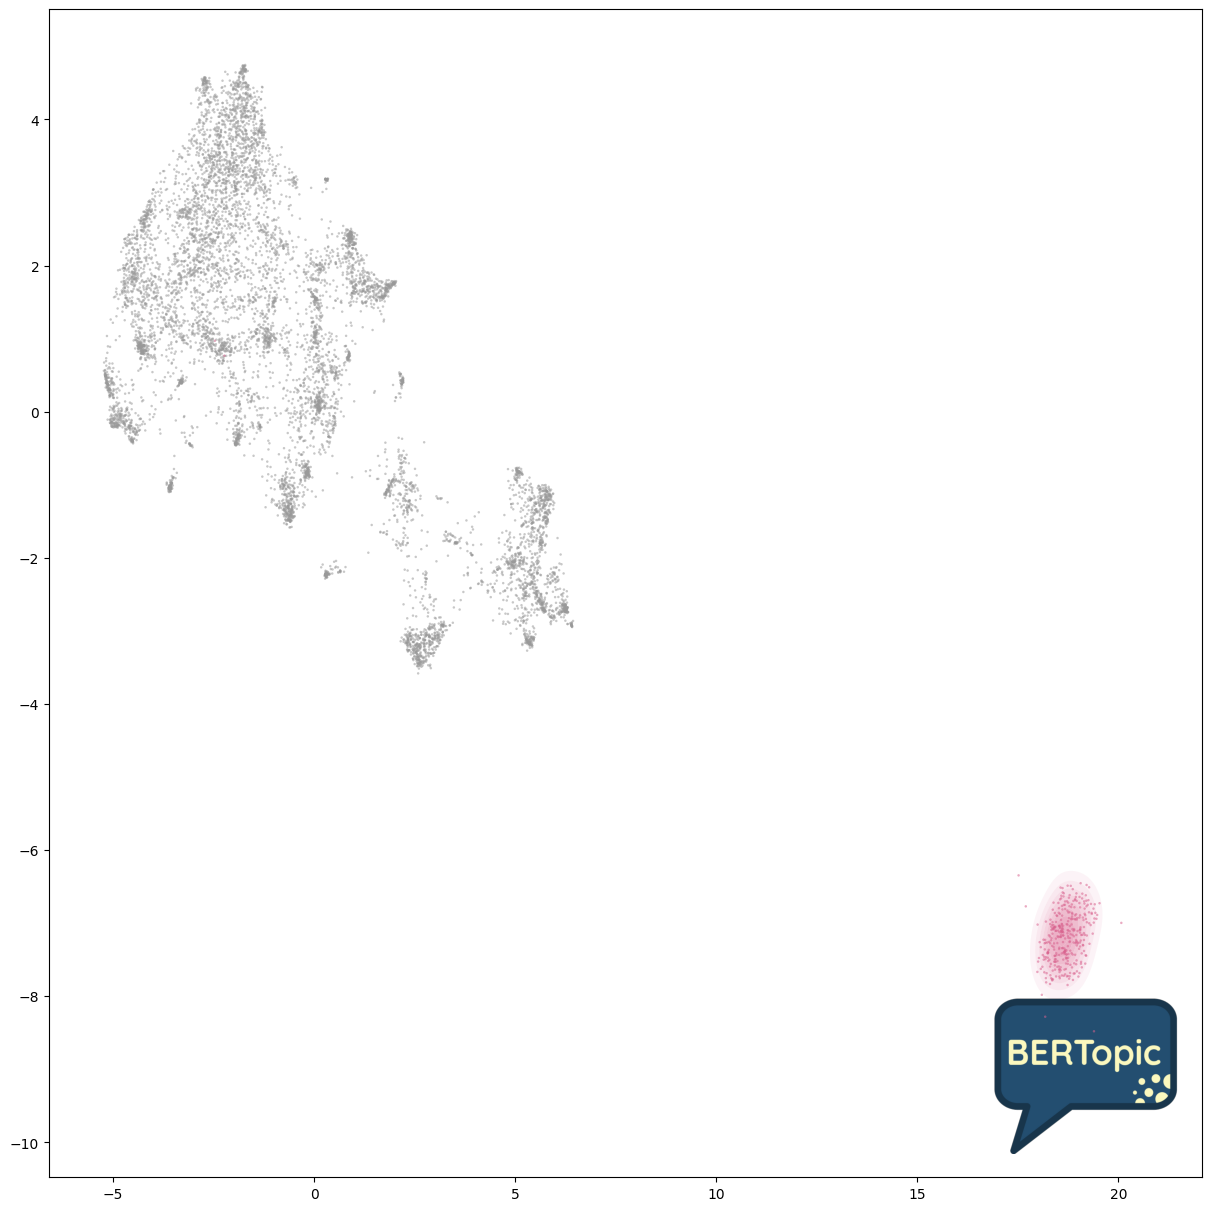

In [21]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="ArXiv - BERTopic",
    sub_title="Topics labeled with `openhermes-2.5-mistral-7b`",
    label_wrap_width=20,
    use_medoids=True,
    logo=bertopic_logo,
    logo_width=0.16
)